In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cmcrameri import cm

import os
from pathlib import Path
import shutil
import gzip
import re
import csv

import timeit

In [25]:
# data_path = 'data/simulation_data'
# output_file = 'processed_data/WDBH_data.csv'
# header = "#N,#rv,#rg,#z,#t_snapshot[myr],#M1[MSUN],#M2[MSUN],#k1,#k2,#id1,#id2,#sma[AU],#ecc,#bin_star_radius0[RSUN],#bin_star_radius1[RSUN],#snapshot, #roche_lobe1_calc[RSUN], #roche_lobe2_calc[RSUN],#radrol0,#radrol1"


In [26]:
data_path = 'data/updated_simulation_data'
output_file = 'processed_data/semergedisrupt_GiantBH_data.csv'


In [27]:
# input_filtered_file = 'processed_data/updated_WDBH_filtered.csv'

# # Initialize an empty list to store rows
# rows = []

# # Open the CSV file for reading
# with open(input_filtered_file, newline='') as csvfile:
#     # Create a CSV reader object
#     csv_reader = csv.reader(csvfile)
#     next(csv_reader)
#     # Iterate over each row in the CSV
#     for row in csv_reader:
#         # Append each row (which is already a list) to the rows list
#         rows.append(row)

# ids = list(dict.fromkeys(np.concatenate((np.array(rows).T[9],np.array(rows).T[10]))))

# ids = [ int(float(id)) for id in ids ]

# print(ids)


# def convert_first_element(lst):
#     if lst[0] == '8':
#         lst[0] = 8.0
#     if lst[0] == '16.0':
#         lst[0] = 16
#     if lst[0] == '32.0':
#         lst[0] = 32
#     return lst

# def convert_third_element(lst):
#     if lst[2] == '8':
#         lst[2] = 8.0
#     return lst


# numbers = np.array(rows)[::, :4]

# str_numbers = []

# for number in numbers:
#     number = convert_first_element(number)
#     number = convert_third_element(number)
#     # Format each number as required
#     formatted_numbers = [f'{num:.1f}' if isinstance(num, float) else f'{num}' for num in number]
    
#     # Join them into the desired string format
#     output_string = f'N{formatted_numbers[0]}_rv{formatted_numbers[1]}_rg{formatted_numbers[2]}_z{formatted_numbers[3]}'
#     str_numbers.append(output_string)

# str_numbers = list(dict.fromkeys(str_numbers))
# str_numbers += str_numbers
# print(str_numbers)

In [28]:
def parse_semerge(log_file):

    with open(log_file, 'r') as f:
        lines = f.readlines()

    parsed_data = []

    for line in lines:
        # Regular expression to extract values
        pattern = r"t=(\d+\.\d+) (\w+) idr=(\d+)\(mr=(\d+\.\d+)\) id1=(\d+)\(m1=(\d+\.\d+)\):id2=(\d+)\(m2=(\d+\.\d+)\) \(r=(\d+\.\d+)\) typer=(\d+) type1=(\d+) type2=(\d+)"


        match = re.match(pattern, line)
        if match:
            row = list(match.groups())
            # Insert mass_merger after id_merger
            row.insert(3, row.pop(3))
            # Replace missing values with '-100'
            for i in range(len(row)):
                if row[i] is None:
                    row[i] = '-100'

            parsed_data.append(row)
    
    return np.array(parsed_data)

In [29]:
all_coll = []
id_Giant = [2, 3, 4, 5, 6, 7, 8, 9]
id_BH = [14]

### Grab all values
# Loop over all model folders
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder);
    # Checks is a folder
    if os.path.isdir(folder_path):
        # Loops through all the snapshots
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder);
            
            ### Find the timeunitsmyr conversion value
            if os.path.isdir(subfolder_path):
                for infosubfolder in os.listdir(subfolder_path):
                    if infosubfolder.endswith('.sh'):
                        infosubfolder_path = os.path.join(subfolder_path, infosubfolder);
                        # Read the file
                        with open(infosubfolder_path, 'r') as file:
                            lines = file.readlines();

                        # Extract the value for timeunitsmyr
                        for line in lines:
                            if line.startswith('timeunitsmyr'):
                                _, value = line.split('=');
                                timeunitsmyr = float(value.strip());
                                print(timeunitsmyr);
                                break
                
                for infosubfolder in os.listdir(subfolder_path):
                    ### Obtain desired data from info files
                    if infosubfolder.endswith('semergedisrupt.log'):
                        infosubfolder_path = os.path.join(subfolder_path, infosubfolder);
                        ### Grab the values of the parameters from the file path
                        # Define the regular expression pattern
                        pattern = r"N(?P<N>[\d.]+)_rv(?P<rv>[\d.]+)_rg(?P<rg>[\d.]+)_z(?P<z>[\d.]+)";
                        # Search for the pattern in the file path
                        match = re.search(pattern, subfolder_path);
                        # If a match is found, extract the values and convert them to floats
                        if match:
                            mod_params = [float(match.group('N')), float(match.group('rv')), float(match.group('rg')), float(match.group('z'))];
                        else:
                            print("Pattern not found in the file path.");
                        
                        # Parse the log file
                        events_all = parse_semerge(infosubfolder_path)
                        
                        events_all_list = events_all.tolist()

                        # Time unit conversion
                        for sublist in events_all_list:
                            sublist[0] = float(sublist[0]) * timeunitsmyr
                        
                        events_all = np.array(events_all_list)

                        # Check WDBH
                        check_GiantBH = ((np.isin(events_all[:, 10].astype(float), id_BH) & np.isin(events_all[:, 11].astype(float), id_Giant)) | (np.isin(events_all[:, 11].astype(float), id_BH) & np.isin(events_all[:, 10].astype(float), id_Giant)))
                        events_GiantBH = events_all[check_GiantBH];

                        # Append the model parameters to the start of each sublist
                        data_list = [mod_params + sublist if type(sublist) is list else mod_params + [sublist] for sublist in events_GiantBH.tolist()];
                            
                        # Append the data to the list of all data
                        if len(data_list) > 0:
                            all_coll += data_list;

884.472
884.472
884.472
884.472
884.472
884.472
2501.66
2501.66
2501.66
2501.66
2501.66
2501.66
2501.66
2501.66
2501.66
7075.78
7075.78
7075.78
7075.78
7075.78
7075.78
7075.78
7075.78
7075.78
20013.3
20013.3
20013.3
20013.3
20013.3
20013.3
20013.3
20013.3
20013.3
400.802
400.802
400.802
400.802
400.802
400.802
400.802
400.802
400.802
1133.64
1133.64
1133.64
1133.64
1133.64
1133.64
1133.64
1133.64
1133.64
3206.41
3206.41
3206.41
3206.41
3206.41
3206.41
3206.41
3206.41
3206.41
9069.11
9069.11
9069.11
9069.11
9069.11
9069.11
9069.11
9069.11
9069.11
3306.65
3306.65
9352.61
9352.61
516.414
516.414
516.414
516.414
516.414
516.414
516.414
516.414
395.298
1460.64
1460.64
1460.64
1460.64
1460.64
1460.64
1460.64
1460.64
1460.64
4131.31
4131.31
4131.31
4131.31
4131.31
4131.31
4131.31
4131.31
4131.31
11685.1
11685.1
11685.1
11685.1
11685.1
11685.1
11685.1
11685.1
11685.1
673.893
673.893
673.893
673.893
673.893
673.893
673.893
673.893
673.893
1906.06
1906.06
1906.06
1906.06
1906.06
1906.06
1906.06


In [30]:
headers = ['N','rv','rg','z','time', 'interaction_type', 'idr', 'mr', 'id1', 'm1', 'id2', 'm2', 'r', 'typer', 'type1', 'type2']

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(all_coll)

In [31]:
### Puts the black hole as the first object

# Load the CSV file into a numpy array
data = np.loadtxt(output_file, delimiter=',', dtype=str, skiprows=1)

# Load the header separately
header = np.loadtxt(output_file, delimiter=',', dtype=str, max_rows=1)

# Convert the relevant columns to integer for comparison
column = data[:, 14].astype(int)

# Create a boolean mask
mask = column != 14

# Swap the values
temp = np.copy(data[mask, 8])
data[mask, 8] = data[mask, 10]
data[mask, 10] = temp

temp = np.copy(data[mask, 9])
data[mask, 9] = data[mask, 11]
data[mask, 11] = temp

temp = np.copy(data[mask, 14])
data[mask, 14] = data[mask, 15]
data[mask, 15] = temp


# Combine the header with the modified data
output_data = np.vstack([header, data])

# Save the modified array back to a CSV file
np.savetxt(output_file, output_data, delimiter=',', fmt='%s')

In [32]:
print(len(data))

522


In [43]:
data_old = [data[i] for i in range(len(data)) if float(data[i][4]) > 9e3]
print(len(data_old))

24


C:\Users\willi\AppData\Local\Temp\ipykernel_18304\2309689820.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax.scatter([], [], c=color, label=label))


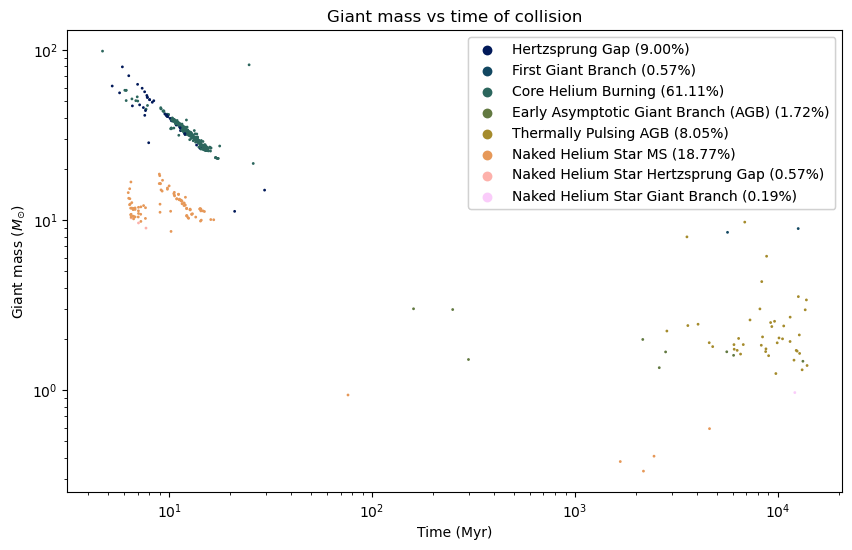

In [34]:

# Load the CSV file into a numpy array
data = np.loadtxt(output_file, delimiter=',', dtype=str, skiprows=1)

mass_BH = data[::, 9].astype(float)

mass_Giant = data[::, 11].astype(float)
type_Giant = data[::, 15].astype(float)
times_WDBH = data[::, 4].astype(float)


colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]


# Get percentages for each type
fractions = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(times_WDBH, mass_Giant, s=1, color=colors_N)
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax.set_title('Giant mass vs time of collision')
ax.set_xscale('log')
ax.set_yscale('log')


# Define the dictionary for the mapping
stage_mapping = {
    0: "Main Sequence (MS), $< 0.7 M_\odot$",
    1: "MS, $> 0.7 M_\odot$",
    2: "Hertzsprung Gap",
    3: "First Giant Branch",
    4: "Core Helium Burning",
    5: "Early Asymptotic Giant Branch (AGB)",
    6: "Thermally Pulsing AGB",
    7: "Naked Helium Star MS",
    8: "Naked Helium Star Hertzsprung Gap",
    9: "Naked Helium Star Giant Branch",
    10: "Helium White Dwarf",
    11: "Carbon/Oxygen White Dwarf",
    12: "Oxygen/Neon White Dwarf",
    13: "Neutron Star",
    14: "Black Hole",
    15: "Massless Remnant"
}

# Replace integers with corresponding text
giant_name_types = [stage_mapping[num] for num in unique_numbers]

# Create a legend
legend_labels = {stage_mapping[N]: f'{stage_mapping[N]} ({frac:.2f}%)' for N, frac in zip(unique_numbers, fractions)}
legend_handles = []
for N in unique_numbers:
    label = legend_labels[stage_mapping[N]]
    color = N_to_color[N]
    legend_handles.append(ax.scatter([], [], c=color, label=label))
first_legend = ax.legend(handles=legend_handles, loc='upper right')
ax.add_artist(first_legend)  # Add the first legend as an artist to the axes

plt.savefig('picture5.png', dpi=500)

In [35]:
# data_path = 'data/updated_simulation_data'
# output_file_all_all = 'processed_data/collisions_all_data.csv'
# output_file_all = 'processed_data/allcollisions_GiantBH_data.csv'
# output_file_nocollision = 'processed_data/nocollision_GiantBH_data.csv'
# output_file_iscollision = 'processed_data/iscollision_GiantBH_data.csv'
# #header = "#N,#rv,#rg,#z,#t_snapshot[myr],#M1[MSUN],#M2[MSUN],#k1,#k2,#id1,#id2,#sma[AU],#ecc,#bin_star_radius0[RSUN],#bin_star_radius1[RSUN],#snapshot, #roche_lobe1_calc[RSUN], #roche_lobe2_calc[RSUN],#radrol0,#radrol1"


In [36]:
output_file_nocollision = 'processed_data/semerge_nocollision_GiantBH_data.csv'

In [37]:
def parse_collision(log_file):

    with open(log_file, 'r') as f:
        lines = f.readlines()

    parsed_data = []

    for line in lines:
        # Regular expression to extract values
        pattern = r"t=([\d.]+)\s+([\w-]+)\s+idm=(\d+)\(mm=([\d.]+)\)\s+(?:id1=(\d+)\(m1=([\d.]+)\))?(?::id2=(\d+)\(m2=([\d.]+)\))?(?::id3=(\d+)\(m3=([\d.]+)\))?(?::id4=(\d+)\(m4=([\d.]+)\))? \(r=([\d.]+)\)\s+typem=(\d+)\s+type1=(\d+)\s+type2=(\d+)(?:\s+type3=(\d+))?(?:\s+type4=(\d+))?(?:\s+b\[RSUN\]=([\d.]+))?(?:\s+vinf\[km/s\]=([\d.]+))?"

        match = re.match(pattern, line)
        if match:
            row = list(match.groups())
            # Insert mass_merger after id_merger
            row.insert(3, row.pop(3))
            # Replace missing values with '-100'
            for i in range(len(row)):
                if row[i] is None:
                    row[i] = '-100'

            parsed_data.append(row)
    
    return np.array(parsed_data)


def parse_semerge(log_file):

    with open(log_file, 'r') as f:
        lines = f.readlines()

    parsed_data = []

    for line in lines:
        # Regular expression to extract values
        pattern = r"t=(\d+\.\d+) (\w+) idr=(\d+)\(mr=(\d+\.\d+)\) id1=(\d+)\(m1=(\d+\.\d+)\):id2=(\d+)\(m2=(\d+\.\d+)\) \(r=(\d+\.\d+)\) typer=(\d+) type1=(\d+) type2=(\d+)"


        match = re.match(pattern, line)
        if match:
            row = list(match.groups())
            # Insert mass_merger after id_merger
            row.insert(3, row.pop(3))
            # Replace missing values with '-100'
            for i in range(len(row)):
                if row[i] is None:
                    row[i] = '-100'

            parsed_data.append(row)
    
    return parsed_data

def get_folder_names(directory):
    try:
        # List all entries in the specified directory
        entries = os.listdir(directory)
        
        # Filter out only the folders
        folders = [entry for entry in entries if os.path.isdir(os.path.join(directory, entry))]
        
        return folders
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Specify the directory
directory_path = r'data/updated_simulation_data'

# Get the list of folder names
str_numbers = get_folder_names(directory_path)

# Print the list of folder names
print("Folder names:", str_numbers)
print("Number of folders:", len(str_numbers))

Folder names: ['N16_rv0.5_rg2.0_z0.002', 'N16_rv0.5_rg2.0_z0.02', 'N16_rv0.5_rg20.0_z0.002', 'N16_rv0.5_rg20.0_z0.02', 'N16_rv0.5_rg8.0_z0.002', 'N16_rv0.5_rg8.0_z0.02', 'N16_rv1.0_rg2.0_z0.0002', 'N16_rv1.0_rg2.0_z0.002', 'N16_rv1.0_rg2.0_z0.02', 'N16_rv1.0_rg20.0_z0.0002', 'N16_rv1.0_rg20.0_z0.002', 'N16_rv1.0_rg20.0_z0.02', 'N16_rv1.0_rg8.0_z0.0002', 'N16_rv1.0_rg8.0_z0.002', 'N16_rv1.0_rg8.0_z0.02', 'N16_rv2.0_rg2.0_z0.0002', 'N16_rv2.0_rg2.0_z0.002', 'N16_rv2.0_rg2.0_z0.02', 'N16_rv2.0_rg20.0_z0.0002', 'N16_rv2.0_rg20.0_z0.002', 'N16_rv2.0_rg20.0_z0.02', 'N16_rv2.0_rg8.0_z0.0002', 'N16_rv2.0_rg8.0_z0.002', 'N16_rv2.0_rg8.0_z0.02', 'N16_rv4.0_rg2.0_z0.0002', 'N16_rv4.0_rg2.0_z0.002', 'N16_rv4.0_rg2.0_z0.02', 'N16_rv4.0_rg20.0_z0.0002', 'N16_rv4.0_rg20.0_z0.002', 'N16_rv4.0_rg20.0_z0.02', 'N16_rv4.0_rg8.0_z0.0002', 'N16_rv4.0_rg8.0_z0.002', 'N16_rv4.0_rg8.0_z0.02', 'N2.0_rv0.5_rg2.0_z0.0002', 'N2.0_rv0.5_rg2.0_z0.002', 'N2.0_rv0.5_rg2.0_z0.02', 'N2.0_rv0.5_rg20.0_z0.0002', 'N2.0_rv0

In [38]:
all_coll = []
id_Giant = [2, 3, 4, 5, 6, 7, 8, 9]
id_BH = [14]



allevents_notmerger = []

for str_number in str_numbers:

    #print("Processing model", str_number)
    # Go through each model individually
    collision_path = f'data/updated_simulation_data/{str_number}/info/initial.semergedisrupt.log'
    conv_path = f'data/updated_simulation_data/{str_number}/info/initial.conv.sh'

    # Read the file
    with open(conv_path, 'r') as file:
        lines = file.readlines();

    # Extract the value for timeunitsmyr
    for line in lines:
        if line.startswith('timeunitsmyr'):
            _, value = line.split('=');
            timeunitsmyr = float(value.strip());
            #print(timeunitsmyr);
            break

    if os.path.exists(collision_path):
        ### Grab the values of the parameters from the file path
        # Define the regular expression pattern
        pattern = r"N(?P<N>[\d.]+)_rv(?P<rv>[\d.]+)_rg(?P<rg>[\d.]+)_z(?P<z>[\d.]+)";
        # Search for the pattern in the file path
        match = re.search(pattern, str_number);
        # If a match is found, extract the values and convert them to floats
        if match:
            mod_params = [float(match.group('N')), float(match.group('rv')), float(match.group('rg')), float(match.group('z'))];
        else:
            print(f"Pattern {str_number} not found in the file path.");
        
        # Parse the log file
        events_all = parse_semerge(collision_path)

        # Time unit conversion
        for sublist in events_all:
            sublist[0] = float(sublist[0]) * timeunitsmyr
    
        events_all = np.array(events_all)
        id_mergers = np.unique(events_all[::, 2].astype(float))
        #print(events_all[0])

        
        # Check GiantBH
        check_GiantBH = ((np.isin(events_all[:, 10].astype(float), id_BH) & np.isin(events_all[:, 11].astype(float), id_Giant)) | (np.isin(events_all[:, 11].astype(float), id_BH) & np.isin(events_all[:, 10].astype(float), id_Giant)))
        print(np.array([events_all[:, 10].astype(float).tolist(),events_all[:, 11].astype(float).tolist()]).T)

        events_GiantBH = events_all[check_GiantBH];
        print(sum(check_GiantBH.tolist()))
        # Convert the relevant columns to integer for comparison
        column = events_GiantBH[:, 11].astype(int)

        # Create a boolean mask
        mask = column != 14

        # Swap the values
        temp = np.copy(events_GiantBH[mask, 4])
        events_GiantBH[mask, 4] = events_GiantBH[mask, 6]
        events_GiantBH[mask, 6] = temp

        temp = np.copy(events_GiantBH[mask, 5])
        events_GiantBH[mask, 5] = events_GiantBH[mask, 7]
        events_GiantBH[mask, 7] = temp

        temp = np.copy(events_GiantBH[mask, 10])
        events_GiantBH[mask, 10] = events_GiantBH[mask, 11]
        events_GiantBH[mask, 11] = temp


        # Check not merger
        check_notmerger = np.isin(events_GiantBH[:, 6].astype(float), id_mergers, invert=True);
        events_notmerger = events_GiantBH#[check_notmerger]

        # Append the model parameters to the start of each sublist
        data_list = [mod_params + sublist if type(sublist) is list else mod_params + [sublist] for sublist in events_notmerger.tolist()];


        # Append the data to the list of all data
        if len(data_list) > 0:
            allevents_notmerger += data_list
        

    else:
        print(f"No such file {collision_path}")



[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [2. 0.]
 [0. 0.]
 [3. 1.]]
0
[[ 1.  1.]
 [ 1.  1.]
 [ 1.  0.]
 ...
 [ 1.  8.]
 [ 0.  0.]
 [ 6. 11.]]
3
[[1. 0.]
 [1. 1.]
 [1. 0.]
 ...
 [3. 0.]
 [3. 1.]
 [0. 0.]]
0
[[1. 1.]
 [1. 1.]
 [1. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
6
[[1. 1.]
 [1. 0.]
 [1. 1.]
 ...
 [3. 0.]
 [3. 1.]
 [0. 0.]]
0
[[ 1.  1.]
 [ 1.  1.]
 [ 1.  0.]
 ...
 [ 0.  0.]
 [13. 11.]
 [ 0.  1.]]
6
[[ 1.  0.]
 [ 1.  1.]
 [ 1.  1.]
 ...
 [ 3.  0.]
 [ 3.  0.]
 [10.  0.]]
3
[[1. 0.]
 [1. 1.]
 [1. 1.]
 ...
 [3. 1.]
 [2. 0.]
 [2. 0.]]
6
[[1. 1.]
 [1. 0.]
 [1. 1.]
 ...
 [3. 0.]
 [3. 0.]
 [3. 1.]]
0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [3. 0.]
 [3. 0.]
 [3. 0.]]
19
[[1. 0.]
 [1. 1.]
 [1. 1.]
 ...
 [3. 0.]
 [3. 0.]
 [3. 0.]]
4
[[1. 1.]
 [1. 1.]
 [1. 0.]
 ...
 [3. 1.]
 [3. 0.]
 [3. 0.]]
0
[[1. 0.]
 [1. 1.]
 [1. 1.]
 ...
 [3. 0.]
 [3. 0.]
 [3. 0.]]
16
[[1. 0.]
 [1. 1.]
 [1. 1.]
 ...
 [2. 0.]
 [3. 0.]
 [3. 0.]]
7
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [3. 0.]
 [3. 1.]
 [3. 1.]]
2
[[ 1.  0.]
 [ 2.  0.]
 [ 1.  0.]

In [39]:
headers = ['N','rv','rg','z','time', 'interaction_type', 'id_merger', 'mass_merger', 'id1', 'm1', 'id2', 'm2', 'id3', 'm3', 'id4', 'm4', 
            'r', 'typem', 'type1', 'type2', 'type3', 'type4', 'b[RSUN]', 'vinf[km/s]']

with open(output_file_nocollision, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(allevents_notmerger)

In [40]:
print(allevents_notmerger)

[[16.0, 0.5, 2.0, 0.02, '29.5701985872', 'disrupt2', '2556646', '7.27956', '2556646', '14.9935', '2264180', '7.27953', '0.227348', '14', '2', '14'], [16.0, 0.5, 2.0, 0.02, '2457.51429672', 'disrupt2', '2436327', '7.57729', '2436327', '0.408753', '1775423', '7.57729', '0.240809', '14', '7', '14'], [16.0, 0.5, 2.0, 0.02, '10565.990959199999', 'disrupt1', '2037225', '5.83492', '2037225', '2.00191', '1680004', '5.83492', '0.0425879', '14', '6', '14'], [16.0, 0.5, 20.0, 0.02, '7.935907330559999', 'disrupt1', '1620445', '7.25427', '1620445', '28.4732', '1753590', '7.25426', '0.177694', '14', '2', '14'], [16.0, 0.5, 20.0, 0.02, '8304.56410488', 'disrupt1', '2251245', '6.31701', '2251245', '1.83518', '1963872', '6.31701', '0.0801236', '14', '6', '14'], [16.0, 0.5, 20.0, 0.02, '8345.9220156', 'disrupt1', '2138448', '7.77565', '2138448', '4.34427', '1900165', '7.77565', '0.0852417', '14', '6', '14'], [16.0, 0.5, 20.0, 0.02, '9946.772112', 'disrupt1', '2497460', '5.98639', '2497460', '1.89676', '

C:\Users\willi\AppData\Local\Temp\ipykernel_18304\424616663.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax.scatter([], [], c=color, label=label))


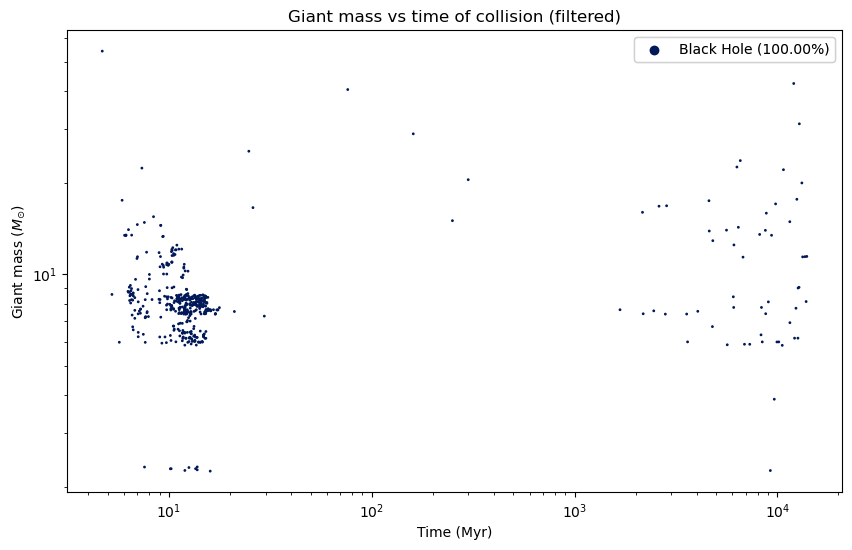

In [41]:

# Load the CSV file into a numpy array
data = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)


mass_BH = data[::, 9].astype(float)

mass_Giant = data[::, 11].astype(float)
type_Giant = data[::, 15].astype(float)
times_WDBH = data[::, 4].astype(float)


colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]


# Get percentages for each type
fractions = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(times_WDBH, mass_Giant, s=1, color=colors_N)
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax.set_title('Giant mass vs time of collision (filtered)')
ax.set_xscale('log')
ax.set_yscale('log')


# Define the dictionary for the mapping
stage_mapping = {
    0: "Main Sequence (MS), $< 0.7 M_\odot$",
    1: "MS, $> 0.7 M_\odot$",
    2: "Hertzsprung Gap",
    3: "First Giant Branch",
    4: "Core Helium Burning",
    5: "Early Asymptotic Giant Branch (AGB)",
    6: "Thermally Pulsing AGB",
    7: "Naked Helium Star MS",
    8: "Naked Helium Star Hertzsprung Gap",
    9: "Naked Helium Star Giant Branch",
    10: "Helium White Dwarf",
    11: "Carbon/Oxygen White Dwarf",
    12: "Oxygen/Neon White Dwarf",
    13: "Neutron Star",
    14: "Black Hole",
    15: "Massless Remnant"
}

# Replace integers with corresponding text
giant_name_types = [stage_mapping[num] for num in unique_numbers]

# Create a legend
legend_labels = {stage_mapping[N]: f'{stage_mapping[N]} ({frac:.2f}%)' for N, frac in zip(unique_numbers, fractions)}
legend_handles = []
for N in unique_numbers:
    label = legend_labels[stage_mapping[N]]
    color = N_to_color[N]
    legend_handles.append(ax.scatter([], [], c=color, label=label))
first_legend = ax.legend(handles=legend_handles, loc='upper right')
ax.add_artist(first_legend)  # Add the first legend as an artist to the axes

plt.savefig('picture6.png', dpi=500)

In [42]:
# for idno,str_number in zip(ids,str_numbers):
#     # str_number = str_numbers[0]
#     # idno = ids[0]
#     log_path = f'data/updated_simulation_data/{str_number}/info/initial.binint.log'
#     conv_path = f'data/updated_simulation_data/{str_number}/info/initial.conv.sh'
#     conv = find_conv(conv_path)
#     print(conv)
#     parsed_log = parse_semerge_file(log_path, time_conv=conv['timeunitcgs'])

#     #print(len(parsed_log))
#     search_id = str(idno)
#     matching_sections = search_sections_by_id(parsed_log, search_id)

#         # for section in matching_sections:
#         #     print(section)
#     sorted_sections = sort_sections_by_time(matching_sections)
#     output_file_path = f'processed_data/binint_outputs/{str_number}_{idno}.txt'
#     write_matching_sections_to_file(sorted_sections, output_file_path)
